Мышковец С.А., v.1 01.05.2023

**Решение задачи:**

ДЗ - оценить возраст человека по изображению. 

Выполнить оптимизацию ранее написанных нейронных сетей. Выбор на ваше усмотрение (лучше брать что то что относительно большое).

Используйте tensorrt. Сравните квантование float16 и float32. 
Дополнительно : tensorflow-lite
Выполнить тестирование времени вывода и опреледилть есть ли падение точности. 

**Вывод**

| Модель | train | valid | test | time train | time eval | time predict
| ----------- | ----------- | ----------- |----------- |----------- |----------- |----------- |
| custom_model | 4,81 | 6,91 | 7,05 | 22 min 10 s  | 2.74 s | 29 s
| quantized_custom_model | 3,57 | 7,02 | 7,03 | 54 min | 10 s | 42 s
| quantized_custom_model_1 | 9,4 | 10,9  | 9,67 | 1 h 24 min 41 s | 10.6 s | 40 S

В модели quantized_custom_model квантизация увеличила более чем в 2 раза увеличила время обучения и в 3,7 раза время на оценку модели, но качество модели снизилось незначительно.
В модели quantized_custom_model_1 квантизация увеличила почти в 4 раза увеличила время обучения и в 3,7 раза время на оценку модели, но качество модели значительно упало.


# Загрузим необходимые библиотеки и проведем разведовательный анализ данных.

In [ ]:
# pip install coremltools

In [41]:
# pip install -q tensorflow-model-optimization

Note: you may need to restart the kernel to use updated packages.


In [87]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Visualization
import cv2 # for ingesting images
print('OpenCV: %s' % cv2.__version__) # print version
import matplotlib 
import matplotlib.pyplot as plt # or data visualizationa
print('matplotlib: %s' % matplotlib.__version__) # print version
import graphviz # for showing model diagram
print('graphviz: %s' % graphviz.__version__) # print version

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, AveragePooling2D, Activation, GlobalMaxPool2D, GlobalAveragePooling2D, Input, MaxPool2D, MultiHeadAttention
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow_model_optimization as tfmot

import gc
from tqdm import tqdm
import sys
import os

OpenCV: 4.7.0
matplotlib: 3.6.3
graphviz: 0.20.1


In [2]:
# Define loss visualization function
def test_val_graph (history,train,val):
    plt.plot(history.history[train], label='Точность на обучающем наборе')
    plt.plot(history.history[val], label='Точность на проверочном наборе')
    plt.xlabel('Цикл обучения')
    plt.ylabel('Точность')
    plt.legend()
    plt.show()
    pass;

In [3]:
import os
main_dir = os.getcwd()

In [4]:
main_dir

'/Users/sviatlanamyshkavets/Documents/Courses/DS TM/47 Композиция глубоких сетей/HW33_Myshkavets S.A.'

In [5]:
# Specify the location of images after you have downloaded them
ImgLocation = main_dir + "/UTKFace"

In [6]:
# Extract age values from file names
age = []
for file in os.listdir(ImgLocation):
    file = int(file.split('_')[0])
    age.append(file)

In [7]:
len(age)

23708

In [8]:
# Extract paths for further data exploration
full_path = []
for file in os.listdir(ImgLocation):
    path = ImgLocation + '/' + file
    full_path.append(path)

In [9]:
# Create pd DataFrame
df = pd.DataFrame({'age': age,  
                   'full_path': full_path, 
                   }
                 )

In [10]:
df.head()

,age,full_path
0,9,/Users/sviatlanamyshkavets/Documents/Courses/D...
1,36,/Users/sviatlanamyshkavets/Documents/Courses/D...
2,86,/Users/sviatlanamyshkavets/Documents/Courses/D...
3,26,/Users/sviatlanamyshkavets/Documents/Courses/D...
4,1,/Users/sviatlanamyshkavets/Documents/Courses/D...


In [11]:
df.describe()

,age
count,23708.000000
mean,33.303484
std,19.886112
min,1.000000
25%,23.000000
50%,29.000000
75%,45.000000
max,116.000000


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23708 entries, 0 to 23707
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23708 non-null  int64 
 1   full_path  23708 non-null  object
dtypes: int64(1), object(1)
memory usage: 370.6+ KB


# Выведем фотографии из файлов, частично проверим верность целевых меток.

**При необходимости при помощи кода ниже пробежимся по папкам и проверим фото детей до 18 лет, удалим явные выбросы. В нашем случае выбран очищенный датасет.**

In [ ]:
test = df[df['age']==1]
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for i in test['full_path']:
#     img = cv2.imread(file)
    img = mpimg.imread(i)
    imgplot = plt.imshow(img)
    plt.xlabel(i)
    print(i)
    plt.show()

array([[<AxesSubplot: title={'center': 'age'}>]], dtype=object)

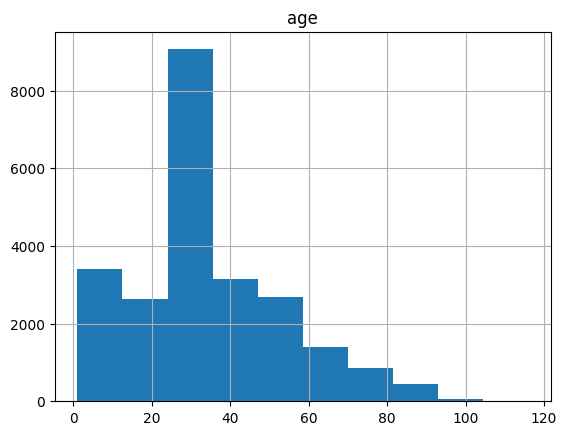

In [13]:
# Explore age distribution
df.hist()

In [14]:
df.groupby('age')['age'].count().sort_values()

age
111       1
103       1
101       2
91        2
115       3
       ... 
24      859
35      880
28      918
1      1123
26     2197
Name: age, Length: 104, dtype: int64

In [15]:
# Delete age values over 99 years
index_age_100 = df[df['age']>99].index
df.drop(index_age_100 , inplace=True)

In [15]:
# from sklearn.preprocessing import LabelEncoder
# labelencoder = LabelEncoder()
# df['age'] = labelencoder.fit_transform(df['age'])

**Разделим данные на тренировочную, тестовую и валидационную выборку.**

In [16]:
from sklearn.model_selection import train_test_split

y = df['age']
X = df['full_path']

In [17]:
train_full, test= train_test_split(
    df, test_size=0.12, stratify=df['age'], random_state=0)

In [18]:
train_full.groupby('age')['age'].count()

age
1     988
2     424
3     254
4     240
5     173
     ... 
92     12
93      4
95      8
96     15
99      8
Name: age, Length: 96, dtype: int64

In [19]:
train_full.shape

(20834, 2)

In [20]:
# Extract valid from train
train, valid = train_full[:-5500], train_full[-5500:]

In [21]:
test.shape

(2842, 2)

In [22]:
test.groupby('age')['age'].count()

age
1     135
2      58
3      35
4      33
5      23
     ... 
92      1
93      1
95      1
96      2
99      1
Name: age, Length: 95, dtype: int64

In [77]:
# Create necessary folders for image storage
os.makedirs('train')

In [78]:
os.makedirs('test')

In [79]:
os.makedirs('valid')

In [23]:
# Create lists for train/test/valid images
train_files = []
for i in train['full_path']:
    train_files.append(i)
for a in train['age']:
    train_files.append(a)

In [24]:
test_files = []
for i in test['full_path']:
    test_files.append(i)
for a in test['age']:
    test_files.append(a)

In [25]:
valid_files = []
for i in valid['full_path']:
    valid_files.append(i)
for a in valid['age']:
    valid_files.append(a)

In [26]:
train_dir = main_dir + '/train'
test_dir = main_dir + '/test'
valid_dir = main_dir + '/valid'

In [84]:
for filename in os.listdir(ImgLocation):
    if filename != '.DS_Store':
        # for i in os.listdir(ImgLocation + '/' + filename):
        file = ImgLocation + '/' + filename
        if file in train_files:
            img = cv2.imread(file)
            img = cv2.resize(img, (224, 224))
            if img.shape[2] == 1:
                img = np.dstack([img, img, img]) # Some images are in  greyscale (1 channel), 
                                                     # therefore convert them to 3 channel
            path = train_dir
            cv2.imwrite(os.path.join(path, filename), img)
        if file in test_files:
            img = cv2.imread(file)
            img = cv2.resize(img, (224, 224))
            if img.shape[2] == 1:
                img = np.dstack([img, img, img])
            path = test_dir
            cv2.imwrite(os.path.join(path, filename), img)
        if file in valid_files:
            img = cv2.imread(file)
            img = cv2.resize(img, (224, 224))
            if img.shape[2] == 1:
                img = np.dstack([img, img, img])
            path = valid_dir
            cv2.imwrite(os.path.join(path, filename), img)

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [28]:
train_datagen=ImageDataGenerator(rescale=1./255.)

In [29]:
test_datagen=ImageDataGenerator(rescale=1./255.)

In [30]:
valid_datagen=ImageDataGenerator(rescale=1./255.)

In [31]:
TARGET_SIZE = (224,224)

train_gen=train_datagen.flow_from_dataframe(
dataframe=train,
directory=main_dir + '/train',
x_col="full_path",
y_col="age",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
color_mode='rgb',
target_size=TARGET_SIZE
)

valid_gen=train_datagen.flow_from_dataframe(
dataframe=valid,
directory=main_dir + '/valid',
x_col="full_path",
y_col="age",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
color_mode='rgb',
target_size=TARGET_SIZE
)

test_gen=test_datagen.flow_from_dataframe(
dataframe=test,
directory=main_dir + '/test',
x_col="full_path",
y_col="age",
batch_size=32,
seed=42,
shuffle=False,
class_mode="raw",
color_mode='rgb',
target_size=TARGET_SIZE
)

Found 15334 validated image filenames.
Found 5500 validated image filenames.
Found 2842 validated image filenames.


# Определим и обучим базовую модель.

**Custom model**

In [42]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, AveragePooling2D, Activation, GlobalMaxPool2D, GlobalAveragePooling2D, Input, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [58]:
target_size = (224,224,3) 
input = Input(shape= target_size) 

x = Conv2D(filters=32, kernel_size=(3,3), activation='relu')(input) 
x = MaxPool2D(2,2)(x) 

x = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(x) 
x = MaxPool2D(2,2)(x) 

x = Conv2D(filters=128, kernel_size=(3,3), activation='relu')(x) 
x = MaxPool2D(2,2)(x) 

x = Conv2D(filters=256, kernel_size=(3,3), activation='relu')(x) 
x = MaxPool2D(2,2)(x) 
x = GlobalMaxPool2D()(x)
x = Dropout(0.25)(x) 
x = Flatten()(x) 
x = Dense(units=128, activation='relu')(x) 
x = Dense(units=64, activation='relu')(x) 
output = Dense(units=1, activation='linear')(x) 

custom_model  = Model(input, output, name= 'Custom_Model')

In [52]:
custom_model.summary()

Model: "Custom_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)      

In [ ]:
# show model structure 
from tensorflow.keras.utils import plot_model 
plot_model(custom_model,show_shapes=True,
    show_dtype=True,
    show_layer_names=True)

In [59]:
# compile model
custom_model.compile(loss='mse', optimizer='rmsprop', metrics=['mae']) 

# initialize callbacks 
reduceLR = ReduceLROnPlateau(monitor='val_mae', patience= 3, verbose= 1, mode='min', factor=  0.2, min_lr = 1e-6) 

early_stopping = EarlyStopping(monitor='val_mae', patience = 5 , verbose=1, mode='min', restore_best_weights= True) 

checkpoint = ModelCheckpoint('CustomModel.weights.hdf5', monitor='val_mae', verbose=1, save_best_only=True, mode= 'min') 

callbacks= [reduceLR, early_stopping, checkpoint]

In [60]:
%%time 

epochs = 30 
custom_model_history = custom_model.fit(train_gen, validation_data=valid_gen, epochs= epochs, callbacks= callbacks)

Epoch 1/30


2023-05-02 15:33:10.274047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


480/480 [==============================] - ETA: 0s - loss: 467.1237 - mae: 16.6714

2023-05-02 15:33:51.053655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_mae improved from inf to 15.10244, saving model to CustomModel.weights.hdf5
480/480 [==============================] - 46s 93ms/step - loss: 467.1237 - mae: 16.6714 - val_loss: 407.1921 - val_mae: 15.1024 - lr: 0.0010
Epoch 2/30
480/480 [==============================] - ETA: 0s - loss: 424.6072 - mae: 15.8943
Epoch 2: val_mae did not improve from 15.10244
480/480 [==============================] - 45s 94ms/step - loss: 424.6072 - mae: 15.8943 - val_loss: 452.7494 - val_mae: 15.5281 - lr: 0.0010
Epoch 3/30
480/480 [==============================] - ETA: 0s - loss: 398.1640 - mae: 15.3852
Epoch 3: val_mae did not improve from 15.10244
480/480 [==============================] - 45s 93ms/step - loss: 398.1640 - mae: 15.3852 - val_loss: 380.3707 - val_mae: 15.7101 - lr: 0.0010
Epoch 4/30
480/480 [==============================] - ETA: 0s - loss: 375.3994 - mae: 14.9523
Epoch 4: val_mae improved from 15.10244 to 14.55857, saving model to CustomModel.weights.hdf5
480/480 [=====

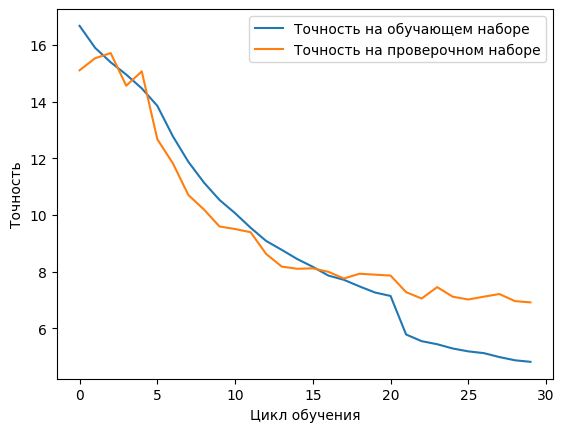

In [61]:
test_val_graph (custom_model_history,'mae','val_mae')

In [62]:
del custom_model

In [63]:
gc.collect()

3859

In [64]:
# load trained model
custom_model =  tf.keras.models.load_model('CustomModel.weights.hdf5')

In [65]:
%%time

# Evaluate the model 
custom_model.evaluate(test_gen)

 3/89 [>.............................] - ETA: 2s - loss: 158.8709 - mae: 7.8509

2023-05-02 15:55:45.725368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


89/89 [==============================] - 3s 29ms/step - loss: 99.0604 - mae: 7.0522
CPU times: user 2.16 s, sys: 1.35 s, total: 3.51 s
Wall time: 2.75 s


[99.06040954589844, 7.052201271057129]

In [96]:
# Predict on 1000 images 
NUM_IMAGES = 1000
idx = np.random.randint (0,len(test),NUM_IMAGES)
expected = []
predicted = []

for idx in tqdm(enumerate(idx), desc='Prediction'):
    link = test.iloc[idx[1]]
    image = plt.imread(link[1])
    img_resized = cv2.resize (image, (224,224))/255 #,
    img_reshaped  = img_resized.reshape (1,224,224,3)
    predict = custom_model.predict(img_reshaped, verbose=0)[0][0];
    
    expected.append (link[1])
    predicted.append (predict)

Prediction: 1000it [00:29, 33.82it/s]


---

# Квантование модели.


Quantization can save memory storage cost and bandwidth for faster and more energy-efficient computation. Quantization has been successfully applied to supervised learning to enable edge deployments of machine learning (ML) models and achieve faster training.

In [66]:
quantized_custom_model = tfmot.quantization.keras.quantize_model(custom_model)

In [67]:
# compile model
quantized_custom_model.compile(loss='mse', optimizer='rmsprop', metrics=['mae']) 

In [68]:
# initialize callbacks 
reduceLR = ReduceLROnPlateau(monitor='val_mae', patience= 3, verbose= 1, mode='min', factor=  0.2, min_lr = 1e-6) 

early_stopping = EarlyStopping(monitor='val_mae', patience = 5 , verbose=1, mode='min', restore_best_weights= True) 

checkpoint = ModelCheckpoint('Quantized_CustomModel.weights.hdf5', monitor='val_mae', verbose=1, save_best_only=True, mode= 'min') 

callbacks= [reduceLR, early_stopping, checkpoint]

In [69]:
epochs = 30 
quantized_custom_model.fit(train_gen, validation_data=valid_gen, epochs= epochs, callbacks= callbacks)

Epoch 1/30


2023-05-02 15:56:05.558288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


480/480 [==============================] - ETA: 0s - loss: 887.1226 - mae: 23.6870

2023-05-02 15:58:37.111266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_mae improved from inf to 19.14114, saving model to Quantized_CustomModel.weights.hdf5
480/480 [==============================] - 171s 354ms/step - loss: 887.1226 - mae: 23.6870 - val_loss: 643.9396 - val_mae: 19.1411 - lr: 0.0010
Epoch 2/30
480/480 [==============================] - ETA: 0s - loss: 392.1638 - mae: 13.7462
Epoch 2: val_mae improved from 19.14114 to 10.47716, saving model to Quantized_CustomModel.weights.hdf5
480/480 [==============================] - 168s 350ms/step - loss: 392.1638 - mae: 13.7462 - val_loss: 225.4711 - val_mae: 10.4772 - lr: 0.0010
Epoch 3/30
480/480 [==============================] - ETA: 0s - loss: 151.3506 - mae: 8.6728
Epoch 3: val_mae improved from 10.47716 to 7.78598, saving model to Quantized_CustomModel.weights.hdf5
480/480 [==============================] - 169s 352ms/step - loss: 151.3506 - mae: 8.6728 - val_loss: 118.9509 - val_mae: 7.7860 - lr: 0.0010
Epoch 4/30
480/480 [==============================] - ETA: 0s - loss: 94.979

54 мин обучалачь модель

In [70]:
del quantized_custom_model

In [71]:
gc.collect()

8828

In [ ]:
# load trained model
quantized_custom_model =  tf.keras.models.load_model('Quantized_CustomModel.weights.hdf5')

# ValueError: Unknown layer: QuantizeLayer. Please ensure this object is passed to the `custom_objects` argument.

In [75]:
with tfmot.quantization.keras.quantize_scope():
    quantized_custom_model = tf.keras.models.load_model('Quantized_CustomModel.weights.hdf5')

In [76]:
%%time

# Evaluate the model 
quantized_custom_model.evaluate(test_gen)

2023-05-02 16:54:42.552400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


89/89 [==============================] - 10s 115ms/step - loss: 99.0989 - mae: 7.0361
CPU times: user 6.85 s, sys: 16.4 s, total: 23.2 s
Wall time: 10.5 s


[99.09888458251953, 7.036126613616943]

In [94]:
# Predict on 1000 images 
NUM_IMAGES = 1000
idx = np.random.randint (0,len(test),NUM_IMAGES)
expected = []
predicted = []

for idx in tqdm(enumerate(idx), desc='Prediction'):
    link = test.iloc[idx[1]]
    image = plt.imread(link[1])
    img_resized = cv2.resize (image, (224,224))/255 #,
    img_reshaped  = img_resized.reshape (1,224,224,3)
    predict = quantized_custom_model.predict(img_reshaped, verbose=0)[0][0];
    
    expected.append (link[1])
    predicted.append (predict)

Prediction: 0it [00:00, ?it/s]2023-05-02 18:35:42.188931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
Prediction: 1000it [00:42, 23.52it/s]


---

In [77]:
target_size = (224,224,3) 
input = Input(shape= target_size) 

x = Conv2D(filters=32, kernel_size=(3,3), activation='relu')(input) 
x = MaxPool2D(2,2)(x) 

x = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(x) 
x = MaxPool2D(2,2)(x) 

x = Conv2D(filters=128, kernel_size=(3,3), activation='relu')(x) 
x = MaxPool2D(2,2)(x) 

x = Conv2D(filters=256, kernel_size=(3,3), activation='relu')(x) 
x = MaxPool2D(2,2)(x) 
x = GlobalMaxPool2D()(x)
x = Dropout(0.25)(x) 
x = Flatten()(x) 
x = Dense(units=128, activation='relu')(x) 
x = Dense(units=64, activation='relu')(x) 
output = Dense(units=1, activation='linear')(x) 

custom_model_1  = Model(input, output, name= 'Custom_Model_1')
quantized_custom_model_1 = tfmot.quantization.keras.quantize_model(custom_model_1)

In [78]:
# compile model
quantized_custom_model_1.compile(loss='mse', optimizer='rmsprop', metrics=['mae']) 

In [79]:
# initialize callbacks 
reduceLR = ReduceLROnPlateau(monitor='val_mae', patience= 3, verbose= 1, mode='min', factor=  0.2, min_lr = 1e-6) 

early_stopping = EarlyStopping(monitor='val_mae', patience = 5 , verbose=1, mode='min', restore_best_weights= True) 

checkpoint = ModelCheckpoint('Quantized_CustomModel_1.weights.hdf5', monitor='val_mae', verbose=1, save_best_only=True, mode= 'min') 

callbacks= [reduceLR, early_stopping, checkpoint]

In [80]:
%%time 

epochs = 30 
quantized_custom_model_1.fit(train_gen, validation_data=valid_gen, epochs= epochs, callbacks= callbacks)

Epoch 1/30


2023-05-02 16:59:07.509710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


480/480 [==============================] - ETA: 0s - loss: 1000.6949 - mae: 26.0274

2023-05-02 17:01:40.605886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_mae improved from inf to 23.38358, saving model to Quantized_CustomModel_1.weights.hdf5
480/480 [==============================] - 173s 358ms/step - loss: 1000.6949 - mae: 26.0274 - val_loss: 832.4333 - val_mae: 23.3836 - lr: 0.0010
Epoch 2/30
480/480 [==============================] - ETA: 0s - loss: 621.0607 - mae: 19.2453
Epoch 2: val_mae improved from 23.38358 to 15.53712, saving model to Quantized_CustomModel_1.weights.hdf5
480/480 [==============================] - 171s 356ms/step - loss: 621.0607 - mae: 19.2453 - val_loss: 454.5974 - val_mae: 15.5371 - lr: 0.0010
Epoch 3/30
480/480 [==============================] - ETA: 0s - loss: 461.0421 - mae: 17.1404
Epoch 3: val_mae did not improve from 15.53712
480/480 [==============================] - 170s 355ms/step - loss: 461.0421 - mae: 17.1404 - val_loss: 723.6787 - val_mae: 23.2982 - lr: 0.0010
Epoch 4/30
480/480 [==============================] - ETA: 0s - loss: 1871.4570 - mae: 38.0372
Epoch 4: val_mae did not impr

In [81]:
del quantized_custom_model_1

In [82]:
gc.collect()

6299

In [84]:
# load trained model
with tfmot.quantization.keras.quantize_scope():
    quantized_custom_model_1 = tf.keras.models.load_model('Quantized_CustomModel_1.weights.hdf5')

In [85]:
%%time

# Evaluate the model 
quantized_custom_model_1.evaluate(test_gen)

2023-05-02 18:25:02.472943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


89/89 [==============================] - 11s 116ms/step - loss: 178.2008 - mae: 9.6725
CPU times: user 6.98 s, sys: 16.4 s, total: 23.4 s
Wall time: 10.6 s


[178.2007598876953, 9.672463417053223]

In [93]:
# Predict on 1000 images 
NUM_IMAGES = 1000
idx = np.random.randint (0,len(test),NUM_IMAGES)
expected = []
predicted = []

for idx in tqdm(enumerate(idx), desc='Prediction'):
    link = test.iloc[idx[1]]
    image = plt.imread(link[1])
    img_resized = cv2.resize (image, (224,224))/255 #,
    img_reshaped  = img_resized.reshape (1,224,224,3)
    predict = quantized_custom_model_1.predict(img_reshaped, verbose=0)[0][0];
    
    expected.append (link[1])
    predicted.append (predict)

Prediction: 1000it [00:40, 24.41it/s]


---